# Stein variational gradient descent

One central challenge in Statistics and Bayesian machine learning is dealing with intractable distributions. In many cases, our models involve complicated distributions, which can be difficult to integrate out or sample from - consider for example the posterior distribution over the parameters of a Bayesian neural network. A great deal of approaches have been devised to enable efficient handling of complicated distributions, broadly falling in two categories: Variational Inference (VI) and Markov Chain Monte Carlo (MCMC) - we focus on the former only here.

Suppose we are working with an intractable distribution $p$. VI seeks to approximate $p$ by another approximate distribution $q$, constrained to be in a tractable family of distributions - such as an independent Gaussian. By optimising a similarity metric between $q$ and $p$, such as the KL-divergence, VI produces a (hopefully) decent approximation which captures some of the important aspects of the target. VI can be much faster than MCMC, but it is an approximate method. The severity of approximation involved in VI is largely affected by the family of the approximate distribution, and can be very large for many applications of interest.

Stein Variational Gradient Descent (SVGD) {cite}`liu2019stein` is an algorithm which enables approximate inference for intractable distributions, wihtout the severe constraints of the approximating family of VI. Much like VI, it minimises the KL divergence between $q$ and $p$, but unlike VI it does not involve heavy assumptions on the family of $q$. Instead, SVGD evolves a finite set of particles, which approximates $q$, by a sequence of transformations such that $q$ gets progressively closer to $p$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Derivation of SVGD

The idea SVGD is to approximate a target distribution $p$ by an approximate distribution $q$, by applying a sequence of transformations to $q$ which will bring it closer to $p$. By applying the transformation (from a restricted family of transformations) which most rapidly reduces the KL divergence, we will obtain an algorithm that looks much like steepest-direction gradient descent.

### Invertible transformations

Suppose we have an initial distribution $q$, which we pass through a transformation $T : \mathbb{R}^N \to \mathbb{R}^N$, that is

$$\begin{align}
z = T(x),~~\text{ where } x \sim q(x).
\end{align}$$

If the map $T$ is invertible, we can easily compute the density of the transformed variable $z$ via the change of variables formula. To ensure $T$ is invertible, let us set $T(x) = x + \epsilon \phi(x)$, where $\epsilon$ is a small coefficient and $\phi : \mathbb{R}^N \to \mathbb{R}^N$. If $\phi$ is smooth and $\epsilon$ is sufficiently small, then $T$ is invertible, which which means we can easily compute the density of $z$. We turn to the question of how to pick an appropriate $\phi$.

### Direction of steepest descent

Let us use the subscript notation $q_{[T]}$ to denote the distribution obtained by passing $q$ through $T$. Then we are interested in picking a $T$ which minimises $\text{KL}(q_{[T]} || p)$. First, we compute the derivative of the KL w.r.t. $\epsilon$, which we obtain in closed form.

<div class="theorem">
    
**Theorem (Gradient of KL is the KSD)** Let $x \sim q(x)$, and $T(x) = x + \epsilon \phi(x)$, where $\phi$ is a smooth function. Then
    
$$\begin{align}
\nabla_{\epsilon}\text{KL}(q_{[T]} || p) \big|_{\epsilon = 0} = - \mathbb{E}_{x \sim q}\left[\text{trace} \mathcal{A}_p \phi(x) \right],
\end{align}$$
    
where $q_{[T]}$ is the density of $T(x)$ and
    
$$\begin{align}
\mathcal{A}_p \phi(x) = \nabla_x \log p(x)\phi^\top(x) + \nabla_x \phi(x).
\end{align}$$
    
</div>
<br>

<details class="proof">
<summary>Proof: Gradient of KL</summary>
    
Let $p_{\left[T^{-1}\right]}(x)$ denote the density of $z = T^{-1}(x)$ when $x \sim p(x)$. By changing the variable of integration from $z$ to $x = T^{-1}(x)$, we obtain
    
$$\begin{align}
\text{KL}(q_{[T]} || p) &= \int q_{[T]}(z) \log \frac{q_{[T]}(z)}{p(z)} dz \\
                        &= \int q(x) \left[ \log q(x) - \log p_{\left[T^{-1}\right]}(x) \right] dx.
\end{align}$$
    
This change of variables is convenient because now only one term in the integral depends on $\epsilon$, that is $p_{\left[T^{-1}\right]}(x)$. Now taking the derivative with respect to $\epsilon$ we obtain
    
$$\begin{align}
\nabla_{\epsilon} \text{KL}(q_{[T]} || p) &= - \int q(x) \nabla_{\epsilon} \log p_{\left[T^{-1}\right]}(x) dx, \\
                                          &= - \int q(x) \nabla_{\epsilon} \log p_{\left[T^{-1}\right]}(x) dx,
\end{align}$$
    
and using the fact that

$$\begin{align}
\log p_{\left[T^{-1}\right]}(x) &= \log p(T(x)) + \log |\nabla_x T(x)|,
\end{align}$$
    
we obtain the expression

$$\begin{align}
\nabla_{\epsilon} \log p_{\left[T^{-1}\right]}(x) &= \nabla \log p(T(x))^\top \nabla_\epsilon T(x) + \nabla_\epsilon \log |\nabla_x T(x)|, \\
                                                  &= \nabla \log p(T(x))^\top \nabla_\epsilon T(x) + \text{trace}\left[(\nabla_x T(x))^{-1} \nabla_\epsilon \nabla_x T(x)\right],
\end{align}$$
    
where we have used the identity
    
$$\begin{align}
\nabla_{\epsilon} \log |\det A| = \text{trace} A^{-1} \nabla_{\epsilon} A,
\end{align}$$
    
we arrive at the following expression for the derivative
    
$$\begin{align}
\nabla_{\epsilon} \text{KL}(q_{[T]} || p) &= - \mathbb{E}_{x \sim q} \left[\nabla \log p(T(x))^\top \nabla_\epsilon T(x) + \text{trace} (\nabla_x T(x))^{-1} \nabla_\epsilon \nabla_x T(x)\right].
\end{align}$$
    
Setting $T(x) = x + \epsilon \phi(x)$ yields the result
    
$$\begin{align}
\nabla_{\epsilon} \text{KL}(q_{[T]} || p) &= - \mathbb{E}_{x \sim q} \left[\nabla \log p(x)^\top \phi(x) + \text{trace}\left[\nabla_x \phi(x) \right]\right], \\
                                          &= - \mathbb{E}_{x \sim q} \left[\text{trace} \mathcal{A}_p \phi(x) \right].
\end{align}$$
    
</details>
<br>


This result gives us the rate of change of the KL as $\epsilon$ increases, for given $\phi$. Now, we want to pick $\phi$ such that $-\mathbb{E}_{x \sim q} \left[\text{trace} \mathcal{A}_p \phi(x) \right]$ is as negative as possible. However, this minimisation is not well defined, because one can scale $\phi$ by an arbitrary scalar making the expectation unbounded. Further, the minimisation is not analytically or computationally tractable either. This issue can be resolved by considering a constrained version of this optimisation problem instead, using Reproducing Kernel Hilbert Spaces (RKHS).

Let $k$ be a positive-definite kernel, defining a corresponding RKHS $\mathcal{H}$ with inner product $\langle\cdot, \cdot \rangle_{\mathcal{H}}$. Let also $\mathcal{H}_D = \mathcal{H} \times ... \times \mathcal{H}$ be the Hilbert space of $D$-dimensional vector valued functions $f = (f_1, ..., f_D) : f_1, ..., f_D \in \mathcal{H}$ with corresponding inner product

$$\begin{align}
\langle f, g \rangle_{\mathcal{H}_D} = \sqrt{\sum_{d = 1}^D \langle f_d, g_d \rangle_{\mathcal{H}_D}^2}.
\end{align}$$

If we now constrain $\phi \in \mathcal{H}_D$ and $|| \phi ||_{\mathcal{H}_D} \leq 1$ we obtain{cite}`liu2016kernelized` the following analytic expression for the direction of steepest descent.

<div class="theorem">
    
**Theorem (Direction of steepest descent of the KL)** The function $\phi^* \in \mathcal{H}_D, || \phi^* ||_{\mathcal{H}_D} \leq 1$ which maximises the rate of decrease KL-divergence is
    
$$\begin{align}
\phi^*(\cdot) = \beta / ||\beta||_{\mathcal{H}_d} ,~~\beta(\cdot) = \mathbb{E}_{x \sim q}\left[ k(x, \cdot) \nabla_x \log p(x) + \nabla_x k(x, \cdot)\right].
\end{align}$$
    
</div>
<br>


<details class="proof">
<summary>Proof: Direction of steepest descent of the KL</summary>
    
For $f \in \mathcal{H}_D$ we have the following equality
    
$$\begin{align}
\langle f, \beta \rangle_{\mathcal{H}_D} &= \sum_{d = 1}^D \langle f_d(\cdot), \beta_d \rangle_{\mathcal{H}} \\
                                          &= \sum_{d = 1}^D \left \langle f_d(\cdot), \mathbb{E}_{x \sim q}\left[k(x, \cdot) \nabla_{x_d} \log p(x) + \nabla_{x_d} k(x, \cdot)\right] \right\rangle_{\mathcal{H}} \\
                                          &= \sum_{d = 1}^D \mathbb{E}_{x \sim q}\left[\nabla_{x_d} \log p(x) \langle f_d(\cdot), k(x, \cdot) \rangle + \langle f_d(\cdot), \nabla_{x_d} k(x, \cdot) \rangle \right] \rangle_{\mathcal{H}} \\
                                          &= \sum_{d = 1}^D \mathbb{E}_{x \sim q}\left[\nabla_{x_d} \log p(x) f_d(x) + \nabla_{x_d} f_d(x) \right] \\
                                          &= \mathbb{E}_{x \sim p}\left[\mathcal{A}_q f(x)\right].
\end{align}$$
    
Therefore, the $f \in \mathcal{H}_D$ which maximises $\mathbb{E}_{x \sim p}\left[\mathcal{A}_q f(x)\right]$ is the one which maximises the inner product $\langle f, \beta \rangle_{\mathcal{H}_D}$, which occurs when $f$ is proportional to $\beta$.
    
</details>
<br>

### Empirical approximation

Now, if we approximate $q$ by a finite set of $N$ particles at locations $x_n^{(i)}, n = 1, ..., N$, at the $i^{th}$ iteration, we obtain at the following iterative algorithm.

<div class="definition">
    
**Algorithm (Stein variational gradient descent)** Given a distribution $p(x)$, a postive definite kernel $k(x, x')$ and a set of particles with initial positions $\{x_n^{(0)}\}_{n=1}^N$, Stein variational gradient descent evolves the particles according to
    
$$\begin{align}
x^{(i + 1)}_n = x^{(i)}_n + \frac{\epsilon^{(i)}}{N}\sum_{m = 1}^N \left[ k(x_n, x_m) \nabla_x \log p(x)|_{x_n} + \nabla_x k(x_m, x) |_{x_n}\right].
\end{align}$$
    
</div>
<br>

## Implementation

The SVGD algorithm is surprisingly easy to implement, while also each step is quite cheap to evaluate. We will use SVGD to approximate a mixture-of-gaussians (MoG) distribution, to allow for multiple modes.

In [2]:
import tensorflow as tf

def mixture_of_gaussians_logprob(locs, scales, probs):
    
    def logprob(x):
        
        # Dimension of x
        D = x.shape[-1]
        
        # Ensure MOG weight probabilities sum to 1
        log_probs = tf.math.log(probs[None, :] / tf.reduce_sum(probs))
        
        # Differences between x and gaussian locations
        diff = x[:, None, :] - locs[None, :, :]
        
        # Compute log of gaussian, including the normalising constant
        quad = -0.5 * tf.reduce_sum((diff / scales) ** 2, axis=2)
        quad = quad - 0.5 * D * tf.math.log(2 * np.pi * tf.reduce_prod(scales, axis=-1) ** 2)
        
        # Compute log-probability using the log-sum-exp trick for stability
        summands = log_probs + quad
        max_summand = tf.reduce_max(summands, axis=1)
        
        summed = tf.reduce_sum(tf.exp(summands - max_summand[:, None]), axis=1)
        summed = max_summand + tf.math.log(summed)
        
        return summed
    
    return logprob

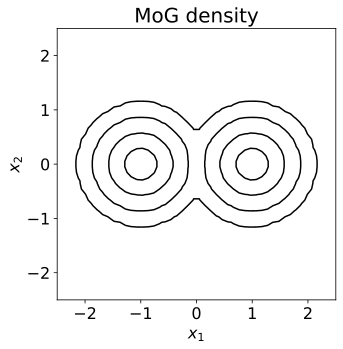

In [40]:
# Float dtype to use
dtype = tf.float32

# Parameters for mixture of gaussians pdf
locs = tf.convert_to_tensor([[-1e0, 0.], [1e0, 0.]], dtype=dtype)
scales = tf.convert_to_tensor([2e-1, 2e-1], dtype=dtype)
probs = tf.convert_to_tensor([5e-1, 5e-1], dtype=dtype)

# Discretisation grid reslution
grid_res = 50

# Create log-probabilty lambda
logprob = mixture_of_gaussians_logprob(locs=locs,
                                       scales=scales,
                                       probs=probs)

# Input locations at which to compute log-probabilities
x_plot = np.linspace(-2.5, 2.5, grid_res)
x_plot = np.stack(np.meshgrid(x_plot, x_plot), axis=-1)
x_plot = tf.convert_to_tensor(np.reshape(x_plot, (-1, 2)), dtype=dtype)

# Compute log-probabilities
logp = logprob(x_plot)

# Reshape to 3D and 2D arrays for plotting
x_plot = np.reshape(x_plot, (grid_res, grid_res, 2))
logp = tf.reshape(logp, (grid_res, grid_res))

# Contourplot levels corresponding to standard deviations
levels = np.max(np.exp(logp)) * \
         np.exp(- np.linspace(4, 0, 5) ** 2)

# Plot density
plt.figure(figsize=(5, 5))
plt.contour(x_plot[:, :, 0],
             x_plot[:, :, 1],
             np.exp(logp),
             colors='black',
             levels=levels)

# Format plot
plt.xticks(np.linspace(-2, 2, 5), fontsize=16)
plt.yticks(np.linspace(-2, 2, 5), fontsize=16)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.title('MoG density', fontsize=20)
plt.show()

In the figure above, the contours are spaced such that they roughly correspond to the standard deviations of each Gaussian. With regards to the kernel $k$, although SVGD can use any positive-semidefinite kernel, we will focus our attention to the standard EQ kernel

$$\begin{align}
k(x, x') = \exp\left(-\frac{1}{2\ell^2} (x - x')^2\right),
\end{align}$$

implemented by the `eq` function below. The `svgd_grad` computes the SVGD gradients for a set of particles, using Tensorflow's batch jacobians.

In [41]:
def eq(lengthscales):
    
    def kernel(x, x_):
    
        diff = x[:, None, :] - x_[None, :, :]
        quad = tf.reduce_sum((diff / lengthscales) ** 2, axis=2)
        exp = tf.exp(-0.5 * quad)
        
        return exp
    
    return kernel


@tf.function
def svgd_grad(x, logprob, kernel):
    
    x_ = tf.convert_to_tensor(x[:], dtype=tf.float32)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        
        tape.watch(x)
        
        logp = logprob(x)
        k = kernel(x, x_)
    
    dlogp = tape.gradient(logp, x)
    dk = tape.batch_jacobian(k, x)
    
    svg = (k @ dlogp + tf.reduce_sum(dk, axis=0)) / x.shape[0]
    
    return svg

### Demo on simple MoG

We can now run SVGD using a modest number of particles initialised in between the two modes.

In [46]:
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x = 2e-1 * np.random.normal(size=(num_particles, 2)).astype(np.float32)

# Create EQ kernel
eq_scales = tf.convert_to_tensor([2e-1, 2e-1], dtype=dtype)
kernel = eq(eq_scales)

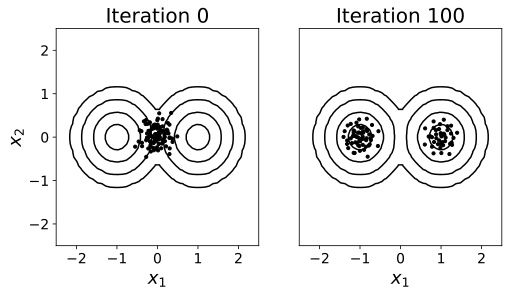

In [47]:
# Step size and number of gradient descent steps
stepsize = 1e-1
num_steps = 100

plt.figure(figsize=(8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contour(x_plot[:, :, 0],
                    x_plot[:, :, 1],
                    np.exp(logp),
                    colors='black',
                    levels=levels)
        
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('$x_1$', fontsize=18)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize=18)
        
        plt.title(f'Iteration {i}', fontsize=20)
    
    # Compute Stein variational gradient
    svg = svgd_grad(x, logprob=logprob, kernel=kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.numpy()
        
plt.show()

We observe that some of the particles fall into each of the two modes, capturing the bimodality of the target, something which VI with a mean-field Gaussian $q$ cannot do.

### Failure mode on MoG

However, SVGD also has failure modes, as illustrated below. If we initialise the particles on one mode of two well-separated Gaussians, then the optimisation gets stuck at a local optimum which fails to capture one of the two modes of the MoG. Therefore, even though SVGD may be able to express more expressive approximate distributions than a simple VI method, it is not guaranteed that the optimisation will be able to find such a distribution.

In [54]:
# Parameters for mixture of gaussians pdf
locs = tf.convert_to_tensor([[-1e0, 0.], [1e0, 0.]], dtype=dtype)
scales = tf.convert_to_tensor([2e-1, 2e-1], dtype=dtype)
probs = tf.convert_to_tensor([0.5, 0.5], dtype=dtype)

# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x = 2e-1 * np.random.normal(size=(num_particles, 2)).astype(np.float32) - np.array([[-1e0, 0]]).astype(np.float32)

# Create EQ kernel
eq_scales = tf.convert_to_tensor([2e-1, 2e-1], dtype=dtype)
kernel = eq(eq_scales)

# Create log-probabilty lambda
logprob = mixture_of_gaussians_logprob(locs=locs,
                                       scales=scales,
                                       probs=probs)

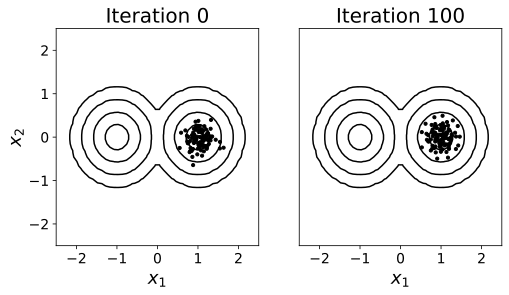

In [55]:
# Step size and number of gradient descent steps
stepsize = 1e-1
num_steps = 100

plt.figure(figsize=(8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contour(x_plot[:, :, 0],
                    x_plot[:, :, 1],
                    np.exp(logp),
                    colors='black',
                    levels=levels)
        
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('$x_1$', fontsize=18)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize=18)
        
        plt.title(f'Iteration {i}', fontsize=20)
    
    # Compute Stein variational gradient
    svg = svgd_grad(x, logprob=logprob, kernel=kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.numpy()
        
plt.show()

## Conclusion

This section presented SVGD, a very interesting general-purpose algorithm for approximate inference. SVGD works by simulating a set of particles, regarded as an empirical approximation of a distribution $q$ which itself approximates the target distribution $p$. By evolving $q$ according to a sequence of transformations, each of which is determined as the direction of steepest decrease in the KL between $q$ and $p$, SVGD can produce a flexible approximation to the target $p$. Although is flexible enough to represent complicated distributions, it may also exhibit failure modes whereby the particles get stuck in a local mode, thus failing to represent other modes of the target. It would be interesting to consider how these issues may be remedied, for example by more sophisticated optimisation schemes, or alternative methods.

## References

```{bibliography} ./references.bib
```